In [1]:
import pandas as pd
import numpy as np
import glob
import scipy
import matplotlib.pyplot as plt
import re
import os
%matplotlib inline

In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown silence'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

In [3]:
train_df = pd.read_pickle('train_df_nov29.pkl')

In [4]:
train_df.head()

,label,label_id,user_id,wav_file,sound
0,left,4,cb8f8307,train/audio/left/cb8f8307_nohash_1.wav,"[-7, 21, -10, 6, -13, 7, 15, -23, 14, -12, 29,..."
1,left,4,b7a0754f,train/audio/left/b7a0754f_nohash_2.wav,"[-2, 6, 7, 3, -2, 2, 6, 6, 4, 5, 5, 11, 9, -1,..."
2,left,4,0132a06d,train/audio/left/0132a06d_nohash_3.wav,"[1, 2, 1, 2, 0, 1, 0, -2, 0, 1, 1, -1, -2, 0, ..."
3,left,4,f92e49f3,train/audio/left/f92e49f3_nohash_4.wav,"[2, 1, -1, -1, 0, 3, 1, -3, -5, -4, -2, 2, 2, ..."
4,left,4,88053e92,train/audio/left/88053e92_nohash_1.wav,"[1, 7, 10, 6, 9, 11, 7, 1, -5, -9, -11, -14, -..."


In [5]:
train_df.tail()

,label,label_id,user_id,wav_file,sound
61518,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[-2027, -2113, 2241, -1327, -4544, -1684, 1804..."
61519,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[-3364, 767, 1743, -362, -2443, 2243, 1069, -3..."
61520,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[680, 466, -405, -2691, -583, 941, 1996, -2570..."
61521,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[-3824, 2775, 368, -2335, -770, -2601, -418, 8..."
61522,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[983, -862, -1930, 1039, -1854, -976, 1725, 36..."


In [3]:
def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob.glob('train/audio/*/*wav')

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label, label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    
    columns_list = ['label', 'label_id', 'user_id', 'wav_file']
    
    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    
    return train_df, valid_df

In [4]:
train_df, valid_df = load_data('./')

There are 57929 train and 6798 val samples


In [5]:
pd.to_pickle(valid_df, 'valid_df.pkl')

In [6]:
# train_df.label.value_counts()

unknown    36818
stop        2134
yes         2116
up          2115
go          2112
right       2111
on          2110
left        2106
no          2105
off         2101
down        2095
silence        6
Name: label, dtype: int64

In [7]:
# valid_df.label.value_counts()

unknown    4221
no          270
down        264
yes         261
go          260
up          260
on          257
off         256
right       256
left        247
stop        246
Name: label, dtype: int64

In [8]:
silence_df = train_df[train_df.label == 'silence']

In [9]:
silence_df

,label,label_id,user_id,wav_file
13113,silence,11,white,train/audio/_background_noise_/white_noise.wav
13114,silence,11,dude,train/audio/_background_noise_/dude_miaowing.wav
13115,silence,11,exercise,train/audio/_background_noise_/exercise_bike.wav
13116,silence,11,pink,train/audio/_background_noise_/pink_noise.wav
13117,silence,11,doing,train/audio/_background_noise_/doing_the_dishe...
13118,silence,11,running,train/audio/_background_noise_/running_tap.wav


In [6]:
from scipy.io import wavfile

In [11]:
silence_data = np.array(silence_df.wav_file.apply(wavfile.read))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [12]:
for sound in silence_data:
    print(sound[0], sound[1].shape)

16000 (960000,)
16000 (988891,)
16000 (980062,)
16000 (960000,)
16000 (1522930,)
16000 (978488,)


In [13]:
silence_chunks = []
clip_len = 16000
for sound in silence_data:
    for i in range(600):
        ind = np.random.randint(0, (len(sound[1])-clip_len))
        silence_chunks.append(sound[1][ind:ind+16000])

In [14]:
silence_chunks = np.array(silence_chunks)

In [15]:
silence_chunks.shape

(3600, 16000)

In [16]:
silence_chunks

array([[ -7437,   4925,  -7282, ...,  21990,  11242, -11347],
       [-12069,  -3646,   7185, ...,   6016,  14489, -24342],
       [-22684, -10710, -10813, ..., -17145,  -1811,  28337],
       ..., 
       [   680,    466,   -405, ...,    231,   2118,   2082],
       [ -3824,   2775,    368, ...,    197,   -492,   2626],
       [   983,   -862,  -1930, ...,   -324,    498,    941]], dtype=int16)

In [17]:
from python_speech_features import mfcc

In [18]:
train_df.label_id.value_counts()

10    36818
8      2134
0      2116
2      2115
9      2112
5      2111
6      2110
4      2106
1      2105
7      2101
3      2095
11        6
Name: label_id, dtype: int64

In [19]:
word_data = np.array(train_df[train_df.label_id != 11].wav_file.apply(wavfile.read))

In [20]:
word_data[0]

(16000, array([ -7,  21, -10, ..., -13, -14, -14], dtype=int16))

In [21]:
word_data2 = [sr_wav[1] for sr_wav in word_data]

In [22]:
word_data2 = np.array(word_data2)

In [23]:
word_data2.shape

(57923,)

In [24]:
word_data2

array([array([ -7,  21, -10, ..., -13, -14, -14], dtype=int16),
       array([-2,  6,  7, ..., -5, -6, -8], dtype=int16),
       array([ 1,  2,  1, ..., -2, -5, -9], dtype=int16), ...,
       array([ 356,   70,  398, ...,  631,  774, 1164], dtype=int16),
       array([  54,   92,  129, ..., -183, -190, -187], dtype=int16),
       array([ 0,  0,  0, ..., -1, -1, -1], dtype=int16)], dtype=object)

In [27]:
train_df = train_df[train_df.label_id != 11]

In [28]:
train_df.shape

(57923, 4)

In [27]:
# train_df["sound"] = word_data2

In [29]:
train_df.head()

,label,label_id,user_id,wav_file
0,left,4,cb8f8307,train/audio/left/cb8f8307_nohash_1.wav
1,left,4,b7a0754f,train/audio/left/b7a0754f_nohash_2.wav
2,left,4,0132a06d,train/audio/left/0132a06d_nohash_3.wav
3,left,4,f92e49f3,train/audio/left/f92e49f3_nohash_4.wav
4,left,4,88053e92,train/audio/left/88053e92_nohash_1.wav


In [27]:
from copy import deepcopy

In [30]:
silence_df2 = pd.DataFrame(columns=['label', 'label_id', 'user_id', 'wav_file'])
for i in range(6):
    silence_df2 = silence_df2.append([silence_df.iloc()[i]]*600)
silence_df2.shape

(3600, 4)

In [31]:
silence_df

,label,label_id,user_id,wav_file
13113,silence,11,white,train/audio/_background_noise_/white_noise.wav
13114,silence,11,dude,train/audio/_background_noise_/dude_miaowing.wav
13115,silence,11,exercise,train/audio/_background_noise_/exercise_bike.wav
13116,silence,11,pink,train/audio/_background_noise_/pink_noise.wav
13117,silence,11,doing,train/audio/_background_noise_/doing_the_dishe...
13118,silence,11,running,train/audio/_background_noise_/running_tap.wav


In [30]:
# silence_chunks.shape

In [31]:
# silence_df2["sound"] = np.zeros((3600,16000))

In [32]:
silence_df2.head()

,label,label_id,user_id,wav_file
13113,silence,11,white,train/audio/_background_noise_/white_noise.wav
13113,silence,11,white,train/audio/_background_noise_/white_noise.wav
13113,silence,11,white,train/audio/_background_noise_/white_noise.wav
13113,silence,11,white,train/audio/_background_noise_/white_noise.wav
13113,silence,11,white,train/audio/_background_noise_/white_noise.wav


In [33]:
train_df = train_df.append(silence_df2)

In [34]:
train_df.reset_index(inplace=True)

In [35]:
train_df.tail()

,index,label,label_id,user_id,wav_file
61518,13118,silence,11,running,train/audio/_background_noise_/running_tap.wav
61519,13118,silence,11,running,train/audio/_background_noise_/running_tap.wav
61520,13118,silence,11,running,train/audio/_background_noise_/running_tap.wav
61521,13118,silence,11,running,train/audio/_background_noise_/running_tap.wav
61522,13118,silence,11,running,train/audio/_background_noise_/running_tap.wav


In [36]:
train_df.drop(labels=["index"], axis=1, inplace=True)

In [37]:
train_df.tail()

,label,label_id,user_id,wav_file
61518,silence,11,running,train/audio/_background_noise_/running_tap.wav
61519,silence,11,running,train/audio/_background_noise_/running_tap.wav
61520,silence,11,running,train/audio/_background_noise_/running_tap.wav
61521,silence,11,running,train/audio/_background_noise_/running_tap.wav
61522,silence,11,running,train/audio/_background_noise_/running_tap.wav


In [38]:
all_sounds = list(word_data2)

In [39]:
all_sounds.extend(silence_chunks)

In [40]:
len(all_sounds)

61523

In [227]:
# for i in range(3600):
#     silence_df2['sound'].iloc()[i] = list(silence_chunks[i])

In [24]:
#! pip install python_speech_features

In [46]:
# plt.figure(figsize=(7,7))
# plt.imshow(mfcc_feat.T, cmap='binary')

In [43]:
def process_wavs(X, max_len = 16000, numcep=40, num_windows=160):
    """Turns audio into a spectrogram, used on validation data"""
    x_mfcc = np.zeros((len(X), num_windows, numcep, 1))
    for i, fn in enumerate(X):
        rate, wave = scipy.io.wavfile.read(fn)
        wave = wave[:max_len]
        wave = np.pad(wave, (0, max_len-wave.shape[0]), 'minimum')
        mfcc_feat = mfcc(wave, rate, numcep=numcep, winlen=(1/num_windows), winstep=(1/num_windows), nfilt=numcep)
        x_mfcc[i,:,:,0] = mfcc_feat
    x_shift = x_mfcc - (np.mean(x_mfcc, axis=1, keepdims=True) + 1e-8)
    return x_shift

Learn parameters for normalization on ENTIRE training data before running the batches.

In [42]:
def process_wavs2(X, max_len = 16000, numcep=40, num_windows=160):
    """Turns audio into a spectrogram, used on training data"""
    x_mfcc = np.zeros((len(X), num_windows, numcep, 1))
    for i, wave in enumerate(X):
        wave = wave[:max_len]
        
        # makes sure we have consistent data, chops or pads.
        wave = np.pad(wave, (0, max_len-wave.shape[0]), 'minimum')
        mfcc_feat = mfcc(wave, 16000, numcep=numcep, winlen=(1/num_windows), winstep=(1/num_windows), nfilt=numcep)
        x_mfcc[i,:,:,0] = mfcc_feat
    
    # TODO: normalize features 
#     x_shift = x_mfcc - (np.mean(x_mfcc, axis=1, keepdims=True) + 1e-8)
    
    return x_shift

In [44]:
# x_train_vec = process_wavs2(all_sounds)
x_val_vec = process_wavs(valid_df.wav_file)

KeyboardInterrupt: 

In [ ]:
# y_train_vec = train_df.label_id.as_matrix()
y_val_vec = valid_df.label_id.as_matrix()

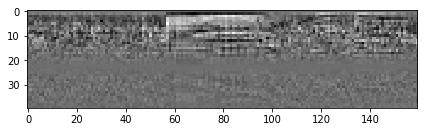

In [43]:
# plt.figure(figsize=(7,7))
# plt.imshow(x_train_vec[6,:,:,0].T, cmap='binary')

In [46]:
import pickle

In [38]:
# pickle.dump(x_train_vec, open('x_train_nov23.pkl', 'wb'))
# pickle.dump(x_test_vec, open('x_test_nov23.pkl', 'wb'))

In [47]:
# print(max(y_train_vec))
# max(y_val_vec)

In [45]:
import keras
import keras.backend as K
# from keras.utils.vis_utils import model_to_dot
# from IPython.display import SVG
# import vis

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [46]:
# y_val_vec2 = keras.utils.to_categorical(y_val_vec, 12)

In [46]:
x_val_vec.shape

NameError: name 'x_val_vec' is not defined

In [47]:
num_labels = 12

In [42]:
# model2 = keras.Sequential([
#     keras.layers.InputLayer(input_shape=x[0].shape),
#     keras.layers.Conv2D(64, kernel_size=(20,8), padding='valid', activation='relu'),
#     keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(64, kernel_size=(10,4), padding='valid', activation='relu'),
#     keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Flatten(),
#     keras.layers.Dense(500, activation="relu"),
#     keras.layers.Dropout(.4),
#     keras.layers.Dense(250, activation="relu"),
#     keras.layers.Dropout(.4),
#     keras.layers.Dense(num_labels, activation="softmax")
# ])
# #SVG(model_to_dot(model2, show_shapes=True).create(prog="dot", format="svg"))
# model2.summary()

In [43]:
# model2.compile(loss='sparse_categorical_crossentropy', 
#                optimizer='nadam',
#                metrics=['accuracy'])

In [44]:
# history2 = model2.fit(x, y, batch_size=512, epochs=50, verbose=1, validation_split=0.2, 
#                       callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc', patience=5,verbose=1)])

In [45]:
#! pip install sklearn

In [49]:
train_df.shape

(61523, 4)

In [50]:
len(all_sounds)

61523

In [48]:
train_df['sound'] = all_sounds

In [49]:
train_df.head()

,label,label_id,user_id,wav_file,sound
0,left,4,cb8f8307,train/audio/left/cb8f8307_nohash_1.wav,"[-7, 21, -10, 6, -13, 7, 15, -23, 14, -12, 29,..."
1,left,4,b7a0754f,train/audio/left/b7a0754f_nohash_2.wav,"[-2, 6, 7, 3, -2, 2, 6, 6, 4, 5, 5, 11, 9, -1,..."
2,left,4,0132a06d,train/audio/left/0132a06d_nohash_3.wav,"[1, 2, 1, 2, 0, 1, 0, -2, 0, 1, 1, -1, -2, 0, ..."
3,left,4,f92e49f3,train/audio/left/f92e49f3_nohash_4.wav,"[2, 1, -1, -1, 0, 3, 1, -3, -5, -4, -2, 2, 2, ..."
4,left,4,88053e92,train/audio/left/88053e92_nohash_1.wav,"[1, 7, 10, 6, 9, 11, 7, 1, -5, -9, -11, -14, -..."


In [50]:
train_df.tail()

,label,label_id,user_id,wav_file,sound
61518,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[-2027, -2113, 2241, -1327, -4544, -1684, 1804..."
61519,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[-3364, 767, 1743, -362, -2443, 2243, 1069, -3..."
61520,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[680, 466, -405, -2691, -583, 941, 1996, -2570..."
61521,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[-3824, 2775, 368, -2335, -770, -2601, -418, 8..."
61522,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[983, -862, -1930, 1039, -1854, -976, 1725, 36..."


In [51]:
train_df.to_pickle('train_df_nov29.pkl')

In [55]:
train_df.label.value_counts()

unknown    36818
silence     3600
stop        2134
yes         2116
up          2115
go          2112
right       2111
on          2110
left        2106
no          2105
off         2101
down        2095
Name: label, dtype: int64

In [52]:
import random

In [116]:
# this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))

In [118]:
# this_train.sample(5)

index    label label_id   user_id  \
label_id                                            
1        5040    5040       no        1  75915c90   
10       46813  46819  unknown       10  ea356919   
         16872  16878  unknown       10  589bce2c   
6        23171  23177       on        6  5e3dde6b   
1        5886    5886       no        1  c1d39ce8   

                                               wav_file  \
label_id                                                  
1        5040      train/audio/no/75915c90_nohash_1.wav   
10       46813  train/audio/three/ea356919_nohash_0.wav   
         16872   train/audio/bird/589bce2c_nohash_0.wav   
6        23171     train/audio/on/5e3dde6b_nohash_1.wav   
1        5886      train/audio/no/c1d39ce8_nohash_3.wav   

                                                            sound  
label_id                                                           
1        5040   [6, 6, 6, 6, 8, 9, 9, 9, 10, 11, 10, 9, 9, 11,...  
10       46813  [-7, -38, -52, -60, -69, -124, -125, -19, -79,...  
         16872  [13, 23, 26, 28, 28, 34, 46, 49, 51, 56, 52, 4...  
6        23171  [14, -51, 8, 6, -50, 44, 2, -31, 28, -21, -14,...  
1        5886   [113, 138, 161, 163, 168, 157, 117, 63, 8, -45...

In [119]:
# shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])

In [121]:
# len(shuffled_ids)

24000

In [124]:
# train_batch_size = 64
# x_batches = []
# y_batches = []
# for start in range(0, len(shuffled_ids), train_batch_size):
#     end = min(start + train_batch_size, len(shuffled_ids))
#     i_train_batch = shuffled_ids[start:end]
#     y_batch = this_train.label_id.values[i_train_batch]
#     x_batch = process_wavs2(this_train.sound.values[i_train_batch])
#     y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
#     x_batches.append(x_batch)
#     y_batches.append(y_batch)

In [129]:
# x_batches[0].shape

(64, 160, 40, 1)

In [132]:
# y_batches[0].shape

(64, 12)

In [53]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import random


In [55]:
train_df.head()

,label,label_id,user_id,wav_file,sound
0,left,4,cb8f8307,train/audio/left/cb8f8307_nohash_1.wav,"[-7, 21, -10, 6, -13, 7, 15, -23, 14, -12, 29,..."
1,left,4,b7a0754f,train/audio/left/b7a0754f_nohash_2.wav,"[-2, 6, 7, 3, -2, 2, 6, 6, 4, 5, 5, 11, 9, -1,..."
2,left,4,0132a06d,train/audio/left/0132a06d_nohash_3.wav,"[1, 2, 1, 2, 0, 1, 0, -2, 0, 1, 1, -1, -2, 0, ..."
3,left,4,f92e49f3,train/audio/left/f92e49f3_nohash_4.wav,"[2, 1, -1, -1, 0, 3, 1, -3, -5, -4, -2, 2, 2, ..."
4,left,4,88053e92,train/audio/left/88053e92_nohash_1.wav,"[1, 7, 10, 6, 9, 11, 7, 1, -5, -9, -11, -14, -..."


In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61523 entries, 0 to 61522
Data columns (total 5 columns):
label       61523 non-null object
label_id    61523 non-null object
user_id     61523 non-null object
wav_file    61523 non-null object
sound       61523 non-null object
dtypes: object(5)
memory usage: 2.3+ MB


In [100]:
# computing the number of samples per batch
# 60 * len(train_df.label_id.unique())

720

In [99]:
%%time
this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 60))
shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
train_batch_size = 13
for start in range(0, len(shuffled_ids), train_batch_size):
    # prevents irregular batch sizes from disrupting the batch
    end = min(start + train_batch_size, len(shuffled_ids))
    i_train_batch = shuffled_ids[start:end]
    y_batch = this_train.label_id.values[i_train_batch]
    x_batch = process_wavs2(this_train.sound.values[i_train_batch])

CPU times: user 4.51 s, sys: 8.52 s, total: 13 s
Wall time: 3.27 s


In [103]:
def train_generator(train_batch_size):
    while True:
        # returns a multiindex of label -> row of each sample
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 60))
        
        # returns a list of sampled 
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            # prevents irregular batch sizes from disrupting the batch
            end = min(start + train_batch_size, len(shuffled_ids))
            
            # rows for each batch
            i_train_batch = shuffled_ids[start:end]
            
            # gets associated data and labels for each batch
            y_batch = this_train.label_id.values[i_train_batch]
            x_batch = process_wavs2(this_train.sound.values[i_train_batch])
#             y_batch = keras.utils.to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [108]:
# process_wavs2(train_df.sound.values[50:60]).shape

(10, 160, 40, 1)

In [111]:
# process_wavs(valid_df.wav_file.values[30:40]).shape

(10, 160, 40, 1)

In [59]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            x_batch = process_wavs(valid_df.wav_file.values[i_val_batch])
            y_batch = valid_df.label_id.values[i_val_batch]
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [104]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(160,40,1)),
    keras.layers.Conv2D(64, kernel_size=(20,8), padding='valid', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(10,4), padding='valid', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dropout(.4),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dropout(.4),
    keras.layers.Dense(num_labels, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', 
               optimizer='nadam',
               metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 141, 33, 64)       10304     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 13, 64)        163904    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 6, 64)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 6, 64)         256       
__________

In [105]:
from tensorflow.python.keras.callbacks import EarlyStopping

In [106]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=0.01,
                           mode='min')]

In [ ]:
history = model.fit_generator(generator=train_generator(512),
                              steps_per_epoch=16,
                              epochs=20,
                              verbose=1)

Epoch 1/20


In [25]:
y_train_pred = estimator.predict(x_train_vec)

23205/23205 [==============================] - 11s 462us/step


In [26]:
y_val_pred = estimator.predict(x_val_vec)

6798/6798 [==============================] - 3s 457us/step


In [45]:
# ! pip install seaborn

In [27]:
import seaborn as sns
from sklearn import metrics

In [28]:
metrics.accuracy_score(y_train_vec, y_train_pred)

0.99151045033397978

In [29]:
metrics.accuracy_score(y_val_vec, y_val_pred)

0.82185937040305967

In [30]:
metrics.recall_score(y_val_vec, y_val_pred, average=None)

array([ 0.95402299,  0.87777778,  0.91153846,  0.94318182,  0.8582996 ,
        0.86328125,  0.87937743,  0.8125    ,  0.88617886,  0.84615385,
        0.78417437])

In [31]:
metrics.precision_score(y_val_vec, y_val_pred, average=None)

array([ 0.84121622,  0.740625  ,  0.6565097 ,  0.34776536,  0.90987124,
        0.7921147 ,  0.65129683,  0.81568627,  0.90082645,  0.59139785,
        0.98015991])

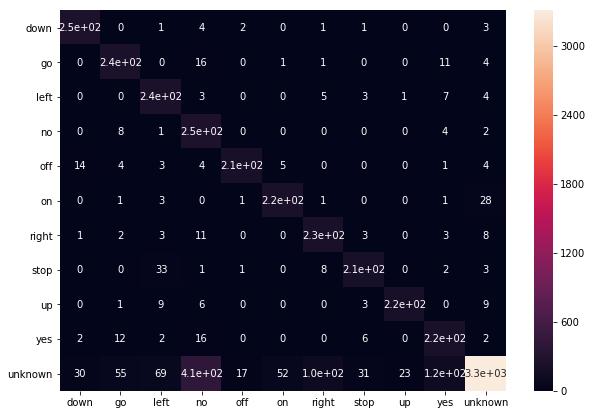

In [32]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_val_vec, y_val_pred), annot=True, xticklabels=['down', 'go', 'left', 'no', 'off',
                                                                               'on', 'right', 'stop', 'up', 'yes',
                                                                               'unknown'], yticklabels=['down', 'go', 'left', 'no', 'off',
                                                                               'on', 'right', 'stop', 'up', 'yes',
                                                                               'unknown'])

In [39]:
test_files = glob.glob('test/audio/*wav')

In [139]:
test_files[:10]

['test/audio/clip_bd6d0fb25.wav',
 'test/audio/clip_3e7a56353.wav',
 'test/audio/clip_c5884a6cb.wav',
 'test/audio/clip_ebf0d1f7b.wav',
 'test/audio/clip_2f714f052.wav',
 'test/audio/clip_05bfe5e6a.wav',
 'test/audio/clip_317b4a205.wav',
 'test/audio/clip_292983fee.wav',
 'test/audio/clip_e086bfc8e.wav',
 'test/audio/clip_d0d7fa566.wav']

In [140]:
# x_test = process_wavs(test_files)

In [33]:
x_test = np.load('x_test_processed.npy')

In [34]:
x_test.shape

(158538, 160, 40, 1)

In [145]:
# np.save('x_test_processed', x_test)

In [35]:
y_test_pred = estimator.predict(x_test)

158538/158538 [==============================] - 72s 453us/step


In [36]:
y_test_pred_label = np.vectorize(id2name.get)(y_test_pred)

In [37]:
y_test_pred_label.shape

(158538,)

In [40]:
test_files2 = [file.replace('test/audio/', "") for file in test_files]

In [41]:
test_files2[:10]

['clip_bd6d0fb25.wav',
 'clip_3e7a56353.wav',
 'clip_c5884a6cb.wav',
 'clip_ebf0d1f7b.wav',
 'clip_2f714f052.wav',
 'clip_05bfe5e6a.wav',
 'clip_317b4a205.wav',
 'clip_292983fee.wav',
 'clip_e086bfc8e.wav',
 'clip_d0d7fa566.wav']

In [42]:
with open('ccmm_submission_nov28_1.csv', 'w') as fout:
    fout.write('fname,label\n')
    for i in range(len(y_test_pred_label)):
        fout.write('{},{}\n'.format(test_files2[i], y_test_pred_label[i]))